In [1]:
###################################################################################################
# Implementation of clustering aggregation algorithms i) Neighbors ii) Hierarchical iii) KwikSort
# Input: People with features, size k
# Output: Clusters of size close to k
# Method: Clustering Aggregation
# Problem Formulation: Given clusterings C1,C2,...,Cm split the aggreement graph into parts of size close to k
# (within some approximation) such that you maximize the sum of the weights of the edges within the clusters.
# The weight of edge e={u,v} is the fraction of clusterings that put u and v in the same cluster
# - maximizes the agreement.
# Purpose: Creating teams for hackthegap
###################################################################################################

In [3]:
import itertools as it
import pandas as pd
import math
import numpy as np
import networkx as nx
import random
import itertools
import math
import matplotlib.pyplot as plt

from itertools import chain
from itertools import izip
from itertools import combinations
from sklearn.metrics import jaccard_similarity_score as JS
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.spatial import distance

In [4]:
# Input: user ids
# Output: Undirected graph where each user is a node and each user has an edge with each other user
def initGraph(features):
    users = list(features.keys())
    # makes graph complete
    edges = combinations(users, 2)
    
    # creating the graph
    user_graph=nx.Graph()
    user_graph.add_nodes_from(users)
    user_graph.add_edges_from(edges)
    
    return user_graph

In [5]:
def data_preprocessing(input_file):
    key_names = {}
    data = pd.read_csv(input_file)
    data = data.reset_index(drop=True)
    
    # Renaming columns
    data_names = data.rename(columns=\
                        # General Interests
                       {'q1-i10::\rfashion': 'Fashion','q1-i11::\rsports': 'Sports','q1-i2::\rpolitics': 'Politics',\
                        'q1-i12::\rarts': 'Arts','q1-i1::\rfinance': 'Finance','q1-i3::\rhealth': 'Health',\
                        'q1-i4::\rtravel': 'Travel','q1-i5::\rentertainment': 'Entertainment','q1-i6::\rmusic': 'Music',\
                        'q1-i7::\reconomics': 'Economics','q1-i8::\rsocial issues': 'SocialIssues',\
                        'q1-i9::\rgaming': 'Gaming','q1-other::\rother interest': 'OtherGeneralInterest',\
                        
                        # Role in Team
                        'q2-i1::\rfront end engineer': 'FrontEnd','q2-i2::\rback end engineer': 'BackEnd',\
                        'q2-i3::\rdata scientist': 'DataScientist','q2-i4::\rdesigner': 'Designer',\
                        'q2-i5::\rios': 'iOS','q2-i6::\randriod': 'Android','q2-other::\rother role': 'OtherRole',\
                        
                        # Experience in Different Fields
                        'q3-i10::\rgame dev': 'GameDev','q3-i1::\rweb app dev': 'WebAppDev',\
                        'q3-i2::\rmobile app dev': 'MobAppDev','q3-i3::\rdata mining': 'DataMining',\
                        'q3-i4::\rmachine intel': 'MachineLearning','q3-i5::\rcomputer networks': 'ComputerNetworks',\
                        'q3-i6::\ralgorithm design': 'AlgoDesign','q3-i7::\rvr/ar': 'VrAr',\
                        'q3-i8::\rhardware': 'Hardware','q3-i9::\rIoT': 'IoT',\
                        'q3-other::\rother experience':'OtherExperience',\
                        
                        # Experience in Programming Languages
                        'q4-i10::\rscala': 'Scala','q4-i1::\rhtml': 'HTML','q4-i2::\rjs': 'JS','q4-i3::\rjava': 'Java',\
                        'q4-i4::\rc++': 'C++','q4-i5::\rpython': 'Python','q4-i6::\rruby': 'Ruby','q4-i6::\rruby': 'Ruby',\
                        'q4-i7::\rc#': 'C#','q4-i8::\rsql': 'SQL','q4-i9::\rswift': 'Swift','q4-i9::\rswift': 'Swift',\
                        'q4-other::\rother languages':'OtherLanguages',\
                        
                        # Overall Skills Levels
                        'q5-i1::\rcommunication skills': 'CommSkill','q5-i2::\rdesign skills': 'DesignSkill',\
                        'q5-i3::\rpresentation skills': 'ReprSkill','q5-i4::\rproject management skills': 'ProjManSkill',\
                        
                        # Motivation
                        'q6-i1::\rhave fun': 'HaveFun','q6-i2::\rlearn tech': 'LearnTech',\
                        'q6-i3::\rwin': 'Win','q6-i4::\rsocialize': 'Socialize','q6-i4::\rsocialize': 'Socialize',\
                        
                        # Goal
                        'q7-i1::\rgreat code': 'GreatCode','q7-i2::\rgreat concept': 'GreatConcept',\
                        'q7-i3::\rgreat design': 'GreatDesign','q7-i4::\rgreat presentation': 'GreatPresentation',\
                        
                        # Teams
                        'team join::\rif want to join a team': 'JoinTeam','team::\rif have team': 'HaveTeam',\
                        'teammates::\rif looking for teammate': 'LookingForTeammate',\
                        'ft1-ft-other::\r# of people wanted': '#PeopleNeeded',\
                        'ft2-ft-other::\rname of team': 'TeamName','ft3-ft-other::\rteam project focus': 'TeamFocus',\
                        'ft4-ft-other::\rteam project technology':'TeamTechnology',\
                        'ft5-i1::\rfront end wanted': 'FrontEndNeeded','ft5-i2::\rback end wanted': 'BackEndNeeded',\
                        'ft5-i4::\rdesigner wanted': 'DesignerNeeded','ft5-i5::\rios person wanted': 'iOSNeeded',\
                        'ft5-i6::\rother roles wanted': 'OtherNeeded','ft5-i7::\rweb dev wanted': 'WebDevNeeded',\
                        'ft6-ft-other::\rteam project experience': 'TeamExperience',\
                        'ft7-ft-other::\rteam emails': 'TeamEmail',\
                        
                        # Id
                        'uid': 'Id'})
    
    # Changing features/skill to binary
    data_names['Fashion'] = data_names['Fashion'].map({'Fashion': 1, None: 0})
    data_names['Sports'] = data_names['Sports'].map({'Sports': 1, None: 0})
    data_names['Arts'] = data_names['Arts'].map({'Arts': 1, None: 0})
    data_names['Finance'] = data_names['Finance'].map({'Finance': 1, None: 0})
    data_names['Health'] = data_names['Health'].map({'Health': 1, None: 0})
    data_names['Travel'] = data_names['Travel'].map({'Travel': 1, None: 0})
    data_names['Entertainment'] = data_names['Entertainment'].map({'Entertainment': 1, None: 0})
    data_names['Music'] = data_names['Music'].map({'Music': 1, None: 0})
    data_names['Economics'] = data_names['Economics'].map({'Economics': 1, None: 0})
    data_names['SocialIssues'] = data_names['SocialIssues'].map({'Social Issues': 1, None: 0})
    data_names['Gaming'] = data_names['Gaming'].map({'Gaming': 1, None: 0})
    # data_names['OtherGeneralInterest'] = data_names['OtherGeneralInterest'].map({'OtherGeneralInterest': 1, None: 0})
    
    data_names['FrontEnd'] = data_names['FrontEnd'].map({'Front-end Engineer': 1, None: 0})
    data_names['BackEnd'] = data_names['BackEnd'].map({'Back-end Engineer': 1, None: 0})
    data_names['DataScientist'] = data_names['DataScientist'].map({'Data Scientist': 1, None: 0})
    data_names['Designer'] = data_names['Designer'].map({'Designer': 1, None: 0})
    data_names['iOS'] = data_names['iOS'].map({'iOS': 1, None: 0})
    data_names['Android'] = data_names['Android'].map({'Android': 1, None: 0})
    # data_names['OtherRole'] = data_names['OtherRole'].map({'OtherRole': 1, None: 0})
    
    data_names['GameDev'] = data_names['GameDev'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['WebAppDev'] = data_names['WebAppDev'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['MobAppDev'] = data_names['MobAppDev'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['DataMining'] = data_names['DataMining'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['MachineLearning'] = data_names['MachineLearning'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['ComputerNetworks'] = data_names['ComputerNetworks'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['AlgoDesign'] = data_names['AlgoDesign'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['VrAr'] = data_names['VrAr'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['Hardware'] = data_names['Hardware'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['IoT'] = data_names['IoT'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    # data_names['OtherRole'] = data_names['OtherRole'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
    #                                                    'Completed multiple projects/courses': 4})
    
    data_names['Scala'] = data_names['Scala'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['HTML'] = data_names['HTML'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['JS'] = data_names['JS'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['Java'] = data_names['Java'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['C++'] = data_names['C++'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['Python'] = data_names['Python'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['Ruby'] = data_names['Ruby'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['C#'] = data_names['C#'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['SQL'] = data_names['SQL'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    data_names['Swift'] = data_names['Swift'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
                                                       'Completed multiple projects/courses': 4})
    # data_names['OtherLanguages'] = data_names['OtherLanguages'].map({None: 1,'No experience': 1,'Some experience': 2,'Completed one project/course': 3,\
    #                                                    'Completed multiple projects/courses': 4})
    
    data_names['CommSkill'] = data_names['CommSkill'].map({None: 0,1:1,2:2,3:3,4:4,5:5})
    data_names['DesignSkill'] = data_names['DesignSkill'].map({None: 0,1:1,2:2,3:3,4:4,5:5})
    data_names['ReprSkill'] = data_names['ReprSkill'].map({None: 0,1:1,2:2,3:3,4:4,5:5})
    data_names['ProjManSkill'] = data_names['ProjManSkill'].map({None: 0,1:1,2:2,3:3,4:4,5:5})

    data_names['HaveFun'] = data_names['HaveFun'].map({None: 0,1:1,2:2,3:3,4:4,5:5})
    data_names['LearnTech'] = data_names['LearnTech'].map({None: 0,1:1,2:2,3:3,4:4,5:5})
    data_names['Win'] = data_names['Win'].map({None: 0,1:1,2:2,3:3,4:4,5:5})
    data_names['Socialize'] = data_names['Socialize'].map({None: 0,1:1,2:2,3:3,4:4,5:5})
    
    data_names['GreatCode'] = data_names['GreatCode'].map({None: 0,1:1,2:2,3:3,4:4,5:5})
    data_names['GreatConcept'] = data_names['GreatConcept'].map({None: 0,1:1,2:2,3:3,4:4,5:5})
    data_names['GreatDesign'] = data_names['GreatDesign'].map({None:0,1:1,2:2,3:3,4:4,5:5})
    data_names['GreatPresentation'] = data_names['GreatPresentation'].map({None: 0,1:1,2:2,3:3,4:4,5:5})
    
    data_names = data_names.fillna(0)
    # Dropping columns not needed
    data = data_names[['Id','Fashion','Sports','Arts','Finance','Health','Travel','Entertainment','Music','Economics',\
                       'SocialIssues','Gaming',\
                       'FrontEnd','BackEnd','DataScientist','Designer','iOS','Android',\
                       'GameDev','WebAppDev','MobAppDev','DataMining','MachineLearning','ComputerNetworks','AlgoDesign',\
                       'VrAr','Hardware','IoT',\
                       'Scala','HTML','JS','Java','C++','Python','Ruby','C#','SQL','Swift',\
                       'CommSkill','DesignSkill','ReprSkill','ProjManSkill',\
                       'HaveFun','LearnTech','Win','Socialize',\
                       'GreatCode','GreatConcept','GreatDesign','GreatPresentation']]
    
    # technology_list = data['Technology'].tolist()
    # unique_technologies = list(set(technology_list))
    
    # Dictionary with key: person id and value: dictionary of features
    person_data = {}; skills = []
    for index, row in data.iterrows():
        interests = []; roles = []; 
        key = row['Id'];
        
        # General Interests
        if row['Fashion']==1:
            interests.append('Fashion') 
        if row['Sports']==1:
            interests.append('Sports')
        if row['Arts']==1:
            interests.append('Arts')
        if row['Finance']==1:
            interests.append('Finance')
        if row['Health']==1:
            interests.append('Health')
        if row['Travel']==1:
            interests.append('Travel')
        if row['Entertainment']==1:
            interests.append('Entertainment')
        if row['Music']==1:
            interests.append('Music')
        if row['Economics']==1:
            interests.append('Economics')
        if row['SocialIssues']==1:
            interests.append('SocialIssues')
        if row['Gaming']==1:
            interests.append('Gaming')
            
        # Role in Team
        if row['FrontEnd']==1:
            roles.append('FrontEnd') 
        if row['BackEnd']==1:
            roles.append('BackEnd')
        if row['DataScientist']==1:
            roles.append('DataScientist')
        if row['Designer']==1:
            roles.append('Designer')
        if row['iOS']==1:
            roles.append('iOS')
        if row['Android']==1:
            roles.append('Android')
            
        # Experience in Different Fields
        fields = {'GameDev':row['GameDev'],'WebAppDev':row['WebAppDev'],'MobAppDev':row['MobAppDev'],\
                  'DataMining':row['DataMining'],'MachineLearning':row['MachineLearning'],\
                  'ComputerNetworks':row['ComputerNetworks'],'AlgoDesign':row['AlgoDesign'],\
                  'VrAr':row['VrAr'],'Hardware':row['Hardware'],'IoT':row['IoT']}


        # Experience in Programming Languages
        languages = {'Scala':row['Scala'],'HTML':row['HTML'],'JS':row['JS'],\
                  'Java':row['Java'],'C++':row['C++'],\
                  'Python':row['Python'],'Ruby':row['Ruby'],\
                  'C#':row['C#'],'SQL':row['SQL'],'Swift':row['Swift']}                                                                            
            
        # Overall Skills Levels
        overall_skills = {'CommSkill':row['CommSkill'],'DesignSkill':row['DesignSkill'],\
                          'ReprSkill':row['ReprSkill'],'ProjManSkill':row['ProjManSkill']}
        
        # Motivation
        motivation = {'HaveFun':row['HaveFun'],'LearnTech':row['LearnTech'],\
                      'Win':row['Win'],'Socialize':row['Socialize']}

        # Goal
        goal = {'GreatCode':row['GreatCode'],'GreatConcept':row['GreatConcept'],\
                      'GreatDesign':row['GreatDesign'],'GreatPresentation':row['GreatPresentation']}
        
        value = {'interests':interests,'roles':roles,'fields':fields,'languages':languages,\
                'overall_skills':overall_skills,'motivation':motivation,'goal':goal}
        
        person_data[key] = value
        

    # Extracting features 1) General interests * 11 2) Roles * 6 3) Experience in fields * 10
    #                     4) Experience in languages * 10 5) Overall skills * 4
    #                     6) Motivation * 4 7) Goal * 4
    
    # create dictionary of person : [features]
    data = data.fillna(0)
    features = \
            {data.loc[idx, 'Id']: [data.loc[idx, 'Fashion'], data.loc[idx, 'Sports'], data.loc[idx, 'Arts'],\
                                   data.loc[idx, 'Finance'], data.loc[idx, 'Health'], data.loc[idx, 'Travel'],\
                                   data.loc[idx, 'Entertainment'], data.loc[idx, 'Music'], data.loc[idx, 'Economics'],\
                                   data.loc[idx, 'SocialIssues'], data.loc[idx, 'Gaming'], data.loc[idx, 'FrontEnd'],\
                                   data.loc[idx, 'BackEnd'], data.loc[idx, 'DataScientist'], data.loc[idx, 'Designer'],\
                                   data.loc[idx, 'iOS'], data.loc[idx, 'Android'], data.loc[idx, 'GameDev'],\
                                   data.loc[idx, 'WebAppDev'], data.loc[idx, 'MobAppDev'], data.loc[idx, 'DataMining'],\
                                   data.loc[idx, 'MachineLearning'], data.loc[idx, 'ComputerNetworks'], data.loc[idx, 'AlgoDesign'],\
                                   data.loc[idx, 'VrAr'], data.loc[idx, 'Hardware'], data.loc[idx, 'IoT'],\
                                   data.loc[idx, 'Scala'], data.loc[idx, 'HTML'], data.loc[idx, 'JS'],\
                                   data.loc[idx, 'Java'], data.loc[idx, 'C++'], data.loc[idx, 'Python'],\
                                   data.loc[idx, 'Ruby'], data.loc[idx, 'C#'], data.loc[idx, 'SQL'],\
                                   data.loc[idx, 'Swift'], data.loc[idx, 'CommSkill'], data.loc[idx, 'DesignSkill'],\
                                   data.loc[idx, 'ReprSkill'], data.loc[idx, 'ProjManSkill'], data.loc[idx, 'HaveFun'],\
                                   data.loc[idx, 'LearnTech'], data.loc[idx, 'Win'], data.loc[idx, 'Socialize'],\
                                   data.loc[idx, 'GreatCode'], data.loc[idx, 'GreatConcept'], data.loc[idx, 'GreatDesign'],\
                                   data.loc[idx, 'GreatPresentation']] \
                                   for idx in range(data.shape[0])}
    
    # for key, value in features.iteritems():
        # print len(value)
    # print 'Features:',features
    # print '*'*500
    # print 'Person data:',person_data
    # print '*'*500
    return data, features, person_data,

In [6]:
def weight_computation(weight_metric,features_user1,features_user2):
    
    weight = float("inf")
    if weight_metric == 'difference':
        weight = 1 - (abs(features_user1 - features_user2)/float(2))
    elif weight_metric == 'jaccard':
        intersect = len(list(set(features_user1) & set(features_user2)))
        union = len(list(set(features_user1) | set(features_user2)))
        weight = intersect / float(union)
    elif weight_metric == 'same':
        if isinstance(features_user1,int):
            if features_user1 == features_user2:
                weight = 1
            else:
                weight = 0
        else:
            idx1 = features_user1.index(1)
            idx2 = features_user2.index(1)
            if idx1 == idx2:
                weight = 1
            else:
                weight = 0
    elif weight_metric == 'euclidean':
        dst = distance.euclidean(features_user1,features_user2)
        weight = 1 /float(1 + dst)
            
    return weight      

In [7]:
# Input: feature vectors
# Output: weighted clusterings based on features, mapping between user pair and weights in different clusterings
# Note!! 0-10: General Interests, 11-16: Role in team, 17-26: Exp in different fields, 
# 27-36: Exp in Programing Languages, 37-40: Skills levels, 41-44: Motivation, 45-48: Goal. 
# that lead to the corresponding number of clusterings i.e. 7

def create_clusterings(features,user_graph):
    
    clusterings = []
    clustering_weights = {}

    # indexes that show where each feature begins, for instance
    # general interests range from 0-10
    indexes = [0,11,17,27,37,41,45]
    weight_metrics = ['jaccard','jaccard','euclidean','euclidean','euclidean','euclidean','euclidean']
    
    # creating the weights for each clustering  - all weights range from 0 to 1
    # general interests (jaccard): weight = Jaccard(set1,set2)
    # role in team (jaccard): Jaccard(set1,set2)
    # experience in different fields (euclidean similarity): 1/1+dst
    # experience in programming languages (euclidean similarity): 1/1+dst
    # experience in overall skills levels (euclidean similarity): 1/1+dst
    # motivation (euclidean similarity): 1/1+dst
    # goal (euclidean similarity): 1/1+dst
    
    counter = 0; values = []
    length_indexes = len(indexes)-1
    for idx, value in enumerate(indexes):
        user_graph_copy = nx.Graph(user_graph)
        
        weight_metric = weight_metrics[idx]
        for user1,user2 in user_graph_copy.edges(data=False):
            key = (user1,user2)
            if idx != length_indexes:
                features_user1 = features[user1][value:indexes[idx+1]]
                features_user2 = features[user2][value:indexes[idx+1]]
            else:
                length_features = len(features[user1])
                features_user1 = features[user1][value:length_features+1]
                features_user2 = features[user2][value:length_features+1]
                
            weight = weight_computation(weight_metric,features_user1,features_user2)
            user_graph_copy.edge[user1][user2]['weight'] = weight
                
            if key in clustering_weights:
                clustering_weights[key].append(weight)
            else:
                clustering_weights[key] = [];
                clustering_weights[key].append(weight)
                              
        clusterings.append(user_graph_copy)
        
    return clusterings, clustering_weights    

In [8]:
# Aggrement_Graph: Creating the aggreement graph used by the proposed team formation algorithms 
# Input: data
# Output: Aggreement Graph 
# Note!! 0-10: General Interests, 11-16: Role in team, 17-26: Exp in different fields, 
# 27-36: Exp in Programing Languages, 37-40: Skills levels, 41-44: Motivation, 45-48: Goal. 
# These are the distinct different features
def similarity_graph(features):
    print 'Creating aggreement graph'
    
    # creating initial unweighted graph
    user_graph = initGraph(features)
    aggreement_graph = nx.Graph(user_graph)
    
    (clusterings, clustering_weights) = create_clusterings(features,user_graph)
    
    for key,value in clustering_weights.iteritems():
        user1 = key[0]; user2 = key[1]
        value[0] = value[0]*10
        value[2] = value[2]*5
        value[3] = value[3]*5
        value[5] = value[5]*5
        value[6] = value[6]*10
        
        weight = sum(value)/float(len(value)+34)
        aggreement_graph.edge[user1][user2]['weight'] = weight
    
    for u in aggreement_graph.nodes():
        aggreement_graph.node[u]['size'] = 1
    
    return aggreement_graph

In [9]:
def merge_nodes(u,v,Merge_AGraph,algo):
    size = float("inf")
    new_node = ()
        
    # 1) create a new cluster node with a) updated cluster nodes (u+v), b) updated cluster size
    if algo == 'kwiksort':
        if isinstance(v,tuple):
            size = len(v) + 1
            new_node = (v,u)
            new_node = tuple(list(new_node[0]) + [new_node[1]])
        else:
            size = 2
            new_node = (v,u)
            
    elif algo == 'hierarchical':
        new_node = (v,u)
        new_node = tuple(chain(*(i if isinstance(i, tuple) else (i,) for i in new_node)))
        size = len(new_node)
        
    # adding new node to graph    
    Merge_AGraph.add_node(new_node)
    Merge_AGraph.node[new_node]['size'] = size
    # 2) for each neighbor of u and v compute average weight edge - Should not matter 
    # if it is u or v because it is a complete graph

    neighbors_u = Merge_AGraph.neighbors(u)
    
    for neighbor in neighbors_u:
        flag = False
        if Merge_AGraph.has_edge(u,neighbor):
            weight_u = Merge_AGraph.edge[u][neighbor]['weight']
        else:
            flag = True
        if Merge_AGraph.has_edge(neighbor,v):    
            weight_v = Merge_AGraph.edge[neighbor][v]['weight']
        else:
            flag = True

        if flag == False:
            new_weight = (weight_u+weight_v)/float(2)
            Merge_AGraph.add_edge(new_node,neighbor) 
            Merge_AGraph.edge[new_node][neighbor]['weight'] = new_weight

    
    # 3) remove old nodes u,v
    Merge_AGraph.remove_node(v)
    Merge_AGraph.remove_node(u)

    return Merge_AGraph

In [10]:
# Hierarchical
# Input: Aggreement Graph, k
# Output: m clusters
def constrained_hierarchical(AGraph,k): 
    li = []
    Copy_AGraph = nx.Graph(AGraph)
    removed_nodes = {}
    weight_flag = False
    while Copy_AGraph.edges and weight_flag == False:
        max_edge_weight = -float("inf")
        for (u,v) in Copy_AGraph.edges(data=False):
            size1 = Copy_AGraph.node[u]['size']
            size2 = Copy_AGraph.node[v]['size']
            weight = Copy_AGraph.edge[u][v]['weight']
                
            if weight > max_edge_weight and size1+size2 <= k:
                new_edge = (u,v)
                max_edge_weight = weight
        
        u = new_edge[0]; v = new_edge[1]
        if max_edge_weight != -float("inf"):
            Copy_AGraph  = merge_nodes(u,v,Copy_AGraph,'hierarchical')
            for (u,data) in Copy_AGraph.nodes(data=True):
                size = data['size']
                if size == k:
                    neighbors = Copy_AGraph.edges(u,data=True)
                    removed_nodes[u] = neighbors

        else:
            weight_flag = True
    
    return Copy_AGraph.nodes(data=False)

In [11]:
# Hierarchical
# Input: Aggreement Graph, k
# Output: m clusters
def unconstrained_hierarchical(AGraph,k): 
    Copy_AGraph = nx.Graph(AGraph)
    removed_nodes = {}
    weight_flag = False
    while Copy_AGraph.edges and weight_flag == False:
        max_edge_weight = -float("inf")
        for (u,v) in Copy_AGraph.edges(data=False):
            size1 = Copy_AGraph.node[u]['size']
            size2 = Copy_AGraph.node[v]['size']
            weight = Copy_AGraph.edge[u][v]['weight']
            if weight > max_edge_weight:
                new_edge = (u,v)
                max_edge_weight = weight
        
        u = new_edge[0]; v = new_edge[1]
        if max_edge_weight != -float("inf") and max_edge_weight >= 0.5:
            Copy_AGraph  = merge_nodes(u,v,Copy_AGraph,'hierarchical')
            for (u,data) in Copy_AGraph.nodes(data=True):
                size = data['size']
                if size == k:
                    neighbors = Copy_AGraph.edges(u,data=True)
                    removed_nodes[u] = neighbors

        else:
            weight_flag = True
        
    for node in Copy_AGraph.nodes(data=False):
        if not isinstance(node,tuple):
            Copy_AGraph.remove_node(node)
            new_node = (node,)
            Copy_AGraph.add_node(new_node)
            

    return Copy_AGraph.nodes(data=False)

In [12]:
# Neighbors 
# Input: Aggreement Graph, k
# Output: m clusters 

# TODO
def neighbors(AGraph,k):
    print 'Running neighbors algorithm'    

In [13]:
# KwikSort
# Input: Aggreement Graph, k
# Output: m clusters
def kwiksort(AGraph,k,person_ids,pairs,num_iter,threshold):
    
    solution = []

    return solution

In [14]:
def write_to_output(solution,features,idx_RMSD,idx_a,idx_s,output_file):
    data = []; names_team = []
    counter = 1
    # print 'Solution in write to output:',solution
    max_cluster = -float("inf")
    for cluster in solution:
        if len(cluster) > max_cluster:
            max_cluster = len(cluster)

    for idx,cluster in enumerate(solution):
        feature_list = []; row = {};
        for person in cluster:
            features_per_person = features[person]
            feature_list.append(features_per_person)
            
        feature_list += [''] * (max_cluster - len(feature_list)+1)
        row['cluster'] = counter  
        row['cluster size'] = len(cluster)
        row['person ids'] = cluster
        row['Avg RMSD'] = idx_RMSD[idx]
        row['Avg A'] = idx_a[idx]
        row['Avg S'] = idx_s[idx]
        for i in range(max_cluster+1):
            column_value = 'Member '+str(i)
            row[column_value] = feature_list[i]
            
        data.append(row)   
        counter+=1
        
    output_solution = pd.DataFrame(data=data)
    person_ids = output_solution['person ids']; cluster_size = output_solution['cluster size']; \
    cluster = output_solution['cluster']
    output_solution.drop(labels=['person ids','cluster size','cluster'], axis=1,inplace = True)
    output_solution.insert(0, 'cluster', cluster)
    output_solution.insert(1, 'cluster size', cluster_size)
    output_solution.insert(2, 'person ids', person_ids)
    
    output_solution.to_csv(output_file, index=False)

In [15]:
def findsubsets(features,m):
    person_ids = list(features.keys())
    return list(itertools.combinations(person_ids, m))

In [16]:
# Computes the centroid from a list of data points
def mean(a):
    return sum(a) / float(len(a))

def centroid(l):
    c = map(mean, zip(*l))  
    return c

In [17]:
def assign_small_clusters(min_team_size,max_team_size,solution,features):
    new_solution = []
    distribute = {}; remove_cluster = []; spacious_clusters = []
    
    # creating a distribution of all clusters and 
    for idx,cluster in enumerate(solution):
        if len(cluster) < min_team_size:
            for person in cluster:
                features_per_person = features[person]
                distribute[person] = features_per_person
            remove_cluster.append(idx)
        elif len(cluster) == max_team_size:
            spacious_clusters.append(cluster)
            remove_cluster.append(idx)
    
    subtract = 0
    for idx in remove_cluster:
        del solution[idx-subtract]
        subtract+=1
    
    cluster_centroids = {}; cluster_lengthts = {}
    for idx,team in enumerate(solution):
        team_features = []; rmsds = []
        for member in team:
            team_features.append(features[member])
        # team_features = np.array(team_features)
        # team_features = team_features[:,8:15].tolist()
        c = centroid(team_features)  
        cluster_centroids[idx] = c
        cluster_lengthts[idx] = len(team)

    
    # print 'Persons to distribute:',distribute
    for person, value in distribute.iteritems():
        features_per_person = features[person]
        min_dist = float("inf"); cluster_id = float("inf")
        for cluster, centroid_values in cluster_centroids.iteritems():
            dst = distance.euclidean(features_per_person,centroid_values)
            if dst < min_dist and cluster_lengthts[cluster] < max_team_size:
                min_dist = dst
                cluster_id = cluster
                
        # print 'Min cluster id:',cluster_id 
        # print 'Appending to cluster:',solution[cluster_id],'person:',person,'with features:',features[person]
        cluster_lengthts[cluster_id]+=1
        solution[cluster_id] = solution[cluster_id] + (person,)

    # print 'Solution after:',solution
            
    solution = solution + spacious_clusters                  
    return solution
                

In [60]:
# constrained_KwikSort
# Input: Aggreement Graph, k, threshold as percentile
# Output: m clusters

def constrained_kwiksort(AGraph,k,threshold):
    solution = [] 
    while len(solution)==0:
        # print('try kwiksort')
        solution = kwiksort_helper(AGraph.copy(),k,threshold,True)
    print('feasible solution found')
    return solution

def constrained_kwiksort_not_random(AGraph,k,threshold):
    solution = [] 
    while len(solution)==0:
        # print('try kwiksort')
        solution = kwiksort_helper(AGraph.copy(),k,threshold,False)
    print('feasible solution found')
    return solution

# unconstrained_KwikSort
# Input: Aggreement Graph, k, threshold
# Output: m clusters
def unconstrained_kwiksort(AGraph,k,threshold):
    # solution should be a list of lists or tuples
    solution= []
    
    ## Fill in here
    while (AGraph.number_of_nodes()>k):
            
        u = AGraph.nodes()[random.randint(0,AGraph.number_of_nodes()-1)]
        neighbors = AGraph.neighbors(u)
        weights = {}
        for neighbor in neighbors:
            weights[neighbor] = AGraph.edge[u][neighbor]['weight']
        weights = sorted(weights.iteritems(), key=lambda (k,v): (v,k))[::-1]
        
        cluster = []
        for i in range(len(weights)):
            if weights[i][1] > threshold:
                cluster.append(weights[i][0])  
        if cluster != []:
            cluster.append(u)
            solution.append(cluster)
            AGraph.remove_nodes_from(cluster)
#         print solution    
        else: print weights[-1][1],threshold
    if AGraph.number_of_nodes()>0: 
        solution.append(AGraph.nodes())
    return solution

# helper function
def kwiksort_helper(AGraph,k,threshold, randomchoice = True):
    # solution should be a list of lists or tuples
    solution= []
    fail = 0 
    percentile = threshold
    
    ## Fill in here
    while (AGraph.number_of_nodes()>k):
        # dynamic threshold (70%tile)
        dist = []
        for edge in AGraph.edges_iter():
            dist.append(AGraph.edge[edge[0]][edge[1]]['weight'])
        threshold = np.percentile(dist, percentile)
        
        # sort neighbors according to weights 
        if randomchoice: 
            u = AGraph.nodes()[random.randint(0,AGraph.number_of_nodes()-1)]
        else:
            u = select_node(AGraph,k)
            
        neighbors = AGraph.neighbors(u)
        weights = {}
        for neighbor in neighbors:
            weights[neighbor] = AGraph.edge[u][neighbor]['weight']
        weights = sorted(weights.iteritems(), key=lambda (k,v): (v,k))[::-1]

        # if found enough similar neighbors, form a cluster; o.w. choose another node
        if weights[k-2][1] > threshold:
            cluster = [x[0] for x in weights[:k-1]] + [u]
            solution.append(cluster)
            AGraph.remove_nodes_from(cluster)
        else: 
            fail = fail+ 1
            if fail > 20: return [] 
    
    if AGraph.number_of_nodes()>0: 
        solution.append(AGraph.nodes())
    return solution

def select_node(AGraph,k):
    maxweights = -1; choice = 0
    for u in AGraph.nodes():
        # sort neighbors according to weights 
        neighbors = AGraph.neighbors(u)
        weights = []
        for neighbor in neighbors:
            weights.append(AGraph.edge[u][neighbor]['weight'])
        weights = sorted(weights)[::-1]

        # if found enough similar neighbors, form a cluster; o.w. choose another node
        if sum(weights[:k-1]) > maxweights:
            maxweights = sum(weights[:k-1])
            choice = u
    return choice

In [74]:
def CK_threshold_test(input_file,team_size,min_team_size,num_iter,threshold):
    (data, features, person_features) = data_preprocessing(input_file)
    pairs = findsubsets(features,2)
    person_ids = list(features.keys())
    
    # creating similarity graph
    AGraph = similarity_graph(features)    
    
    forplot =[]
    
    print '*'*50
    con_kwik_rmsd = []
    con_kwik_a = []; con_kwik_s = []; con_kwik_clusters_a = []; con_kwik_clusters_s = []
    for j in range(10,100,5):
        print 'threshold:',j, 'th percentile'
        for i in range(6):
            IAGraph = nx.Graph(AGraph)
#             print 'Running constrained kwiksort for time:',i
            solution = constrained_kwiksort(IAGraph,team_size,j)[:]
#             print 'Computing Root Mean Square Deviation'
            (score_RMSD,clusters_RMSD,idx_RMSD_CK) = rmsd(solution,features)
            con_kwik_rmsd.append(score_RMSD)
#             print 'Computing Silhouette Index'
            (a_score,s_score,clusters_a,clusters_s,idx_a_CK,idx_s_CK) = silhouette_index(solution,features)
            con_kwik_a.append(a_score); con_kwik_s.append(s_score) 
            con_kwik_clusters_a.append(clusters_a); con_kwik_clusters_s.append(clusters_s)
        score_RMSD = sum(con_kwik_rmsd)/float(len(con_kwik_rmsd))
        a_score = sum(con_kwik_a)/float(len(con_kwik_a)); s_score = sum(con_kwik_s)/float(len(con_kwik_s))
        
        print 'Root Mean Square Deviation for constrained kwiksort is:',score_RMSD
        print 'A score for constrained kwiksort is:',a_score
        print 'S score for constrained kwiksort is:',s_score
        forplot.append([j,score_RMSD,a_score,s_score])
    return forplot

def CK_random_test(input_file,team_size,min_team_size,num_iter,threshold):
    (data, features, person_features) = data_preprocessing(input_file)
    pairs = findsubsets(features,2)
    person_ids = list(features.keys())  
    AGraph = similarity_graph(features)    

    forplot =[]
    
    print '*'*50
    con_kwik_rmsd = []
    con_kwik_a = []; con_kwik_s = []; con_kwik_clusters_a = []; con_kwik_clusters_s = []
    for j in [True, False]:
        print 'random select nodes in each iteration:',j
        for i in range(10):
            IAGraph = nx.Graph(AGraph)
#             print 'Running constrained kwiksort for time:',i
            if j:
                solution = constrained_kwiksort(IAGraph,team_size,70)[:]
            else:
                solution = constrained_kwiksort_not_random(IAGraph,team_size,70)[:]
#             print 'Computing Root Mean Square Deviation'
            (score_RMSD,clusters_RMSD,idx_RMSD_CK) = rmsd(solution,features)
            con_kwik_rmsd.append(score_RMSD)
#             print 'Computing Silhouette Index'
            (a_score,s_score,clusters_a,clusters_s,idx_a_CK,idx_s_CK) = silhouette_index(solution,features)
            con_kwik_a.append(a_score); con_kwik_s.append(s_score) 
            con_kwik_clusters_a.append(clusters_a); con_kwik_clusters_s.append(clusters_s)
        score_RMSD = sum(con_kwik_rmsd)/float(len(con_kwik_rmsd))
        a_score = sum(con_kwik_a)/float(len(con_kwik_a)); s_score = sum(con_kwik_s)/float(len(con_kwik_s))
        
        print 'Root Mean Square Deviation for constrained kwiksort is:',score_RMSD
        print 'A score for constrained kwiksort is:',a_score
        print 'S score for constrained kwiksort is:',s_score
        forplot.append([j,score_RMSD,a_score,s_score])
    return forplot

In [20]:
def pairwise(t):
    pairs = list(itertools.combinations(t, 2))
    return pairs

In [21]:
def rmsd(solution,features):
    score = 0
    # print 'Solution:',solution
    # print 'Features:',features
    rmsds = []; clusters_rmsd = []; idx_rmsd = {}
    
    for idx,team in enumerate(solution):
        team_features = []; rmsds = []
        for member in team:
            team_features.append(features[member])
        # team_features = np.array(team_features)
        # team_features = team_features[:,7:15].tolist()
        # team_features = team_features.tolist()
        c = centroid(team_features)   
        # print 'Centroid is:',c
        for person in team_features:
            # print 'Person is:',person
            # print 'MSE:',mean_squared_error(person, c)
            rms = sqrt(mean_squared_error(person, c))
            # print 'RMS is:',rms
            rmsds.append(rms)
            
        avg_per_cluster = sum(rmsds)/float(len(rmsds))
        idx_rmsd[idx] = avg_per_cluster
        # print 'Average cluster is:',avg_per_cluster
        clusters_rmsd.append(avg_per_cluster)
        # print
    
    
    score = sum(clusters_rmsd)/float(len(clusters_rmsd))
    # print 'RMSD Score:',score
    return score,clusters_rmsd,idx_rmsd

In [22]:
def silhouette_index(solution,features):
    score = 0
    a_precomp = {}; a = {}; avg_per_cluster = []; a_avg_of_clusters = []; s_avg_of_clusters = []
    b_precomp = {}; b = {}; rms_per_user = []
    s = {};
    team_members = {}; non_team_members = {};
    idx_a = {}; idx_b = {}; idx_s = {}
    members = []; users = []
    
    # list of all users and team members
    for idx,team in enumerate(solution):
        for member in team:
            users.append(member)
            copy_team = list(team)
            copy_team.remove(member)
            remaining_team = copy_team
            team_members[member] = remaining_team

    # list of non-team members
    for member in users:
        team = team_members[member]
        non_team = list(set(users) - set(team))
        copy_team = list(non_team)
        copy_team.remove(member)
        non_team_members[member] = copy_team

    # computing a - compactness
    for idx,team in enumerate(solution):
        if len(team) > 1:
            pairs = pairwise(team) 
        else:
            pairs = ((team[0],team[0]),)
            
        sum_sed = 0
        for pair in pairs:
            u1 = pair[0]; x = features[u1];
            u2 = pair[1]; y = features[u2];
            # rms = sqrt(mean_squared_error(x[7:15], y[7:15]))
            rms = sqrt(mean_squared_error(x, y))
            if u1 in a_precomp:
                a_precomp[u1].append(rms)
            else:
                a_precomp[u1] = []
                a_precomp[u1].append(rms)
                
            if u2 in a_precomp:
                a_precomp[u2].append(rms)
            else:
                a_precomp[u2] = []
                a_precomp[u2].append(rms)  
        
        for key,value in a_precomp.iteritems():
            if len(team) > 1:
                avg_per_user = sum(value)/float(len(team) - 1)
            else:
                avg_per_user = sum(value)/float(len(team))
            # a(i)
            a[key] = avg_per_user                
            avg_per_cluster.append(avg_per_user)
        
        if avg_per_cluster:
            avg_cluster = sum(avg_per_cluster)/float(len(avg_per_cluster))
        else:
            avg_cluster = 0
            
        idx_a[idx] = avg_cluster
        a_avg_of_clusters.append(avg_cluster)
        a_precomp = {}; avg_per_cluster = []
    
    a_score = sum(a_avg_of_clusters)/float(len(a_avg_of_clusters))
    
    # computing b - separation
    for key,value in non_team_members.iteritems():
        x = features[key]
        for non_member in value:
            y = features[non_member]
            # rms = sqrt(mean_squared_error(x[7:15], y[7:15]))
            rms = sqrt(mean_squared_error(x, y))
            rms_per_user.append(rms)

        min_dist = min(rms_per_user)
        b[key] = min_dist
        rms_per_user = []
    
    for key, value in a.iteritems():
        # You want a to be small (distance from same cluster points)
        # You want b to be large (distance from different cluster points)
            
        if b[key]!=a[key]:
            s[key] = (b[key] - a[key])/float(max(b[key],a[key]))
        else:
            s[key] = 0 
    
    s_cluster = []; avg_clusters = []
    for idx,team in enumerate(solution):
        for member in team:
            s_cluster.append(s[member])

        cluster_avg = sum(s_cluster)/float(len(s_cluster))
        idx_s[idx] = cluster_avg
        s_avg_of_clusters.append(cluster_avg)
        s_cluster = []
    
    s_score = sum(s_avg_of_clusters)/float(len(s_avg_of_clusters))
    return (a_score,s_score,a_avg_of_clusters,s_avg_of_clusters,idx_a,idx_s)

In [23]:
def test():
    test_features = {}
    test_features[1] = [2,1,1,3]; test_features[2] = [1,0,0,1]; test_features[5] = [1,0,0,1]
    test_features[3] = [1,0,0,1]; test_features[4] = [1,1,0,0]
    team1 = (1,2,5); team2 = (3,4)
    test_solution = []; test_solution.append(team1); test_solution.append(team2)
    (score_RMSD,clusters_RMSD) = rmsd(test_solution,test_features)
    print 'Root Mean Square Deviation for constrained hierarchical is:',score_RMSD
    (a_score,s_score,clusters_a,clusters_s) = silhouette_index(test_solution,test_features)
    print 'A score for constrained hierarchical is:',a_score
    print 'S score for constrained hierarchical is:',s_score
    print 'A score cluster averages for constrained hierarchical is:',clusters_a
    print 'S score cluster averages for constrained hierarchical is:',clusters_s
    print 'Finished with test'    

In [76]:
def main(input_file,team_size,min_team_size,num_iter,threshold):
    
    # creating the feature vector
    (data, features, person_features) = data_preprocessing(input_file)
    pairs = findsubsets(features,2)
    person_ids = list(features.keys())
    
    # creating similarity graph
    AGraph = similarity_graph(features)  
    
    
    # creating test sample for rmsd
    # test()

    IAGraph = nx.Graph(AGraph)
    print 'Number of persons:',nx.number_of_nodes(IAGraph)
    print 'Running constrained hierarchical'
    solution = constrained_hierarchical(IAGraph,team_size)
    counter = 0
    for cluster in solution:
        for person in cluster:
            counter+=1
            
    print 'Solution persons:',counter
    # print 'Solution:',solution
    solution = assign_small_clusters(min_team_size,team_size,solution,features)
    # print 'Solution',solution
    print 'Computing Root Mean Square Deviation'
    (score_RMSD,clusters_RMSD,idx_RMSD_CH) = rmsd(solution,features)
    print 'Root Mean Square Deviation for constrained hierarchical is:',score_RMSD
    print 'Computing Silhouette Index'
    (a_score,s_score,clusters_a,clusters_s,idx_a_CH,idx_s_CH) = silhouette_index(solution,features)
    print 'A score for constrained hierarchical is:',a_score
    print 'S score for constrained hierarchical is:',s_score
    print 'A score cluster averages for constrained hierarchical is:',clusters_a
    print 'S score cluster averages for constrained hierarchical is:',clusters_s
    # print 'Writing to file'
    write_to_output(solution,person_features,idx_RMSD_CH,idx_a_CH,idx_s_CH,'BHConstrainedHierarch.csv')
    
    print '*'*50
    IAGraph = nx.Graph(AGraph)
    print 'Running unconstrained hierarchical'
    solution = unconstrained_hierarchical(IAGraph,team_size)
    
    counter = 0
    for cluster in solution:
        for person in cluster:
            counter+=1
            
    print 'Solution persons:',counter
    print 'Computing Root Mean Square Deviation'
    (score_RMSD,clusters_RMSD,idx_RMSD_UH) = rmsd(solution,features)
    print 'Root Mean Square Deviation for unconstrained hierarchical is:',score_RMSD
    print 'Computing Silhouette Index'
    (a_score,s_score,clusters_a,clusters_s,idx_a_UH,idx_s_UH) = silhouette_index(solution,features)
    print 'A score for unconstrained hierarchical is:',a_score
    print 'S score for unconstrained hierarchical is:',s_score
    print 'A score cluster averages for unconstrained hierarchical is:',clusters_a
    print 'S score cluster averages for unconstrained hierarchical is:',clusters_s
    # print 'Writing to file'
    write_to_output(solution,person_features,idx_RMSD_UH,idx_a_UH,idx_s_UH,'BHUnconstrainedHierarch.csv')
    
    print '*'*50
    con_kwik_rmsd = []
    con_kwik_a = []; con_kwik_s = []; con_kwik_clusters_a = []; con_kwik_clusters_s = []
    for i in range(6):
        IAGraph = nx.Graph(AGraph)
        print 'Running constrained kwiksort for time:',i
        solution = constrained_kwiksort(IAGraph,team_size,70)
        '''temperary: offset the cluster with size one 
        
        '''
        # solution = solution[:-1]
        print 'Computing Root Mean Square Deviation'
        (score_RMSD,clusters_RMSD,idx_RMSD_CK) = rmsd(solution,features)
        con_kwik_rmsd.append(score_RMSD)
        print 'Computing Silhouette Index'
        (a_score,s_score,clusters_a,clusters_s,idx_a_CK,idx_s_CK) = silhouette_index(solution,features)
        con_kwik_a.append(a_score); con_kwik_s.append(s_score) 
        con_kwik_clusters_a.append(clusters_a); con_kwik_clusters_s.append(clusters_s)
    
    score_RMSD = sum(con_kwik_rmsd)/float(len(con_kwik_rmsd))
    a_score = sum(con_kwik_a)/float(len(con_kwik_a)); s_score = sum(con_kwik_s)/float(len(con_kwik_s))
    print 'Root Mean Square Deviation for constrained kwiksort is:',score_RMSD
    print 'A score for constrained kwiksort is:',a_score
    print 'S score for constrained kwiksort is:',s_score
    print 'A score cluster average indicative for constrained kwiksort is:',clusters_a
    print 'S score cluster average indicative for constrained kwiksort is:',clusters_s
    counter = 0
    for cluster in solution:
        for person in cluster:
            counter+=1
            
    print 'Solution persons:',counter
    write_to_output(solution,person_features,idx_RMSD_CK,idx_a_CK,idx_s_CK,'BHConstrainedKwiksort.csv')
        
#     print '*'*50
#     uncon_kwik_rmsd = []
#     uncon_kwik_a = []; uncon_kwik_s = []; uncon_kwik_clusters_a = []; uncon_kwik_clusters_s = []
#     for i in range(2):
#         IAGraph = nx.Graph(AGraph)
#         print 'Running unconstrained kwiksort'
#         solution = unconstrained_kwiksort(IAGraph,team_size,1/float(2.5))
# #         print 'Solution:',[len(x) for x in solution]
        
#         '''temperary: offset the cluster with size one 
        
#         '''
#         solution = [x for x in solution if len(x)>1]

#         print 'Computing Root Mean Square Deviation'
#         (score_RMSD,clusters_RMSD,idx_RMSD_UK) = rmsd(solution,features)
#         uncon_kwik_rmsd.append(score_RMSD)
#         print 'Computing Silhouette Index'
#         (a_score,s_score,clusters_a,clusters_s,idx_a_UK,idx_s_UK) = silhouette_index(solution,features)
#         uncon_kwik_a.append(a_score); uncon_kwik_s.append(s_score) 
#         uncon_kwik_clusters_a.append(clusters_a); uncon_kwik_clusters_s.append(clusters_s)
    
#     score_RMSD = sum(uncon_kwik_rmsd)/float(len(uncon_kwik_rmsd))
#     a_score = sum(uncon_kwik_a)/float(len(uncon_kwik_a)); s_score = sum(uncon_kwik_s)/float(len(uncon_kwik_s))
#     print 'Root Mean Square Deviation for unconstrained kwiksort is:',score_RMSD
#     print 'A score for unconstrained kwiksort is:',a_score
#     print 'S score for unconstrained kwiksort is:',s_score
#     print 'A score cluster average indicative for unconstrained kwiksort is:',clusters_a
#     print 'S score cluster average indicative for unconstrained kwiksort is:',clusters_s
#     write_to_output(solution,person_features,idx_RMSD_UK,idx_a_UK,idx_s_UK,'BHUnconstrainedKwiksort.csv')


In [77]:
# Team constraints: 1) Each team is a team of approximately 5 2) Similar users and interests are grouped together 
input_file = 'Bostonhacks_clean(s).csv'
dataset_file = 'boston_dataset.csv'
num_iter = 1
threshold = 1/float(100)
# Removing first empty row from dataset -- TODO
with open(input_file,'r') as f, open(dataset_file,'w') as f1:
    # next(f) # skip header line
    for line in f:
        f1.write(line)
        
data = pd.read_csv(dataset_file)    

max_team_size = 5
min_team_size = 4
main(dataset_file, max_team_size, min_team_size, num_iter, threshold)

Creating aggreement graph
Number of persons: 94
Running constrained hierarchical
Solution persons: 94
Computing Root Mean Square Deviation
Root Mean Square Deviation for constrained hierarchical is: 0.671762823998
Computing Silhouette Index
A score for constrained hierarchical is: 1.06487615811
S score for constrained hierarchical is: -0.251262824236
A score cluster averages for constrained hierarchical is: [1.2940223056003255, 1.346991700257765, 0.36141680516200214, 1.029805676495949, 1.276108627078605, 1.391002890790538, 0.9824939106968336, 1.2006282090974258, 1.1150761748914857, 0.9207656835226061, 1.124798217451069, 1.0370939187491648, 0.9567858169293382, 1.1462090735260708, 1.1313136193317113, 0.9652889920367569, 1.027195787344877, 0.9883336762645755, 0.9373159189498617]
S score cluster averages for constrained hierarchical is: [-0.3909214275609673, -0.40772020044137103, 0.639995467050918, -0.26556405087611407, -0.4598026716234502, -0.3696514438084074, -0.282697991921177, -0.33165

______________

### <center> Below is for testing the effect of different percentile on Constrained Kwiksort</center>

In [75]:
forplot = CK_random_test(dataset_file, max_team_size, min_team_size, num_iter, threshold)

Creating aggreement graph
**************************************************
random select nodes in each iteration: True
feasible solution found
feasible solution found
feasible solution found
feasible solution found
feasible solution found
feasible solution found
feasible solution found
feasible solution found
feasible solution found
feasible solution found
Root Mean Square Deviation for constrained kwiksort is: 0.704140641275
A score for constrained kwiksort is: 1.11174928482
S score for constrained kwiksort is: -0.303953165817
random select nodes in each iteration: False
feasible solution found
feasible solution found
feasible solution found
feasible solution found
feasible solution found
feasible solution found
feasible solution found
feasible solution found
feasible solution found
feasible solution found
Root Mean Square Deviation for constrained kwiksort is: 0.687761654502
A score for constrained kwiksort is: 1.08660425111
S score for constrained kwiksort is: -0.277488213818


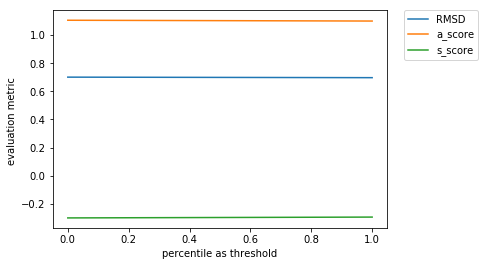

In [73]:
temp = np.array(forplot)
plt.plot(temp[:,0],temp[:,1], label="RMSD")
plt.plot(temp[:,0],temp[:,2],label="a_score")
plt.plot(temp[:,0],temp[:,3],label="s_score")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim = (0,0.2)
plt.xlabel('percentile as threshold')
plt.ylabel('evaluation metric ')

plt.show()